Basic encoder-decoder architecture encodes the input sequence into a fixed-length context vector, which is a performance bottleneck according to Bahdanau et al. [@bahdanau2016neural]. They proposed a attention mechanism to improve the performance of RNN encoder-decoder models by helping the decoder to focus on the most relevant parts of the input sequence when generating the output sequence.

## How does the attention mechanism work?
The purpose of the attention is to compute a context vector for the decoder to generate output sequence.
The whole process is done in 3 steps, as illustrated in the following figure [@bahdanau2016neural]:

1. the encoder computes annotations for every word in the input sequence.
2. the decode use an alignment model to compute attention scores based on the annotations from the encoder
3. finally, the decoder compute the context vector using the attention scores and the annotations

<p style="text-align:center;">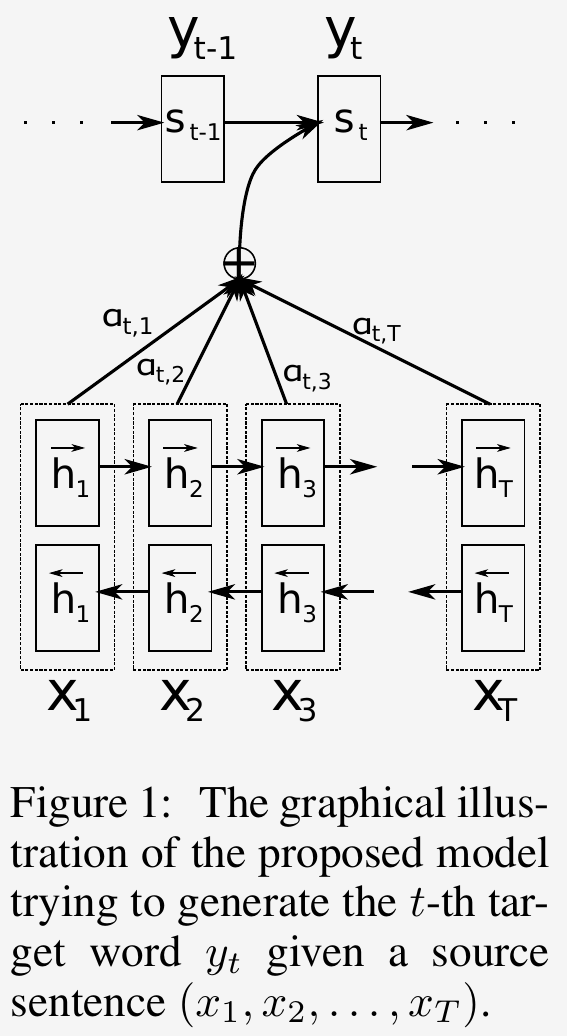
<br/>Image source: Bahdanau et al. [@bahdanau2016neural]</p>

### Step 1: compute annotations
The encoder uses a bidirectional RNN (BiRNN) so that the annotation of each word $j$ summarizes both the preceding and following words.
The results are a forward hidden state $\overrightarrow{h_j}$ and a backward hidden state $\overleftarrow{h_j}$, 
which are concatenated to form the annotation: $h_j=\left[\begin{array}{c}\overrightarrow{h}_j \\ \overleftarrow{h}_j\end{array}\right]$

### step 2: compute attention scores
The decoder uses an alignment model to compute attention scores. The authors chose a single-layer MLP as the alignment model,
$$
a(s_{i-1}, h_j) = v_a^\intercal\ tanh(W_a s_{i-1} + U_a h_j)
$$
$W_a$, $U_a$ and $v_a$ are weight matrices. $h_j$ is the $j$-th annotation from the source sequence. $s_{i-1}$ is the decoder state at time $i-1$.

At time $i$, given the $j$-th annotation $h_j$, the attention score $e_{ij}$ is computed using the previous decoder state $s_{i-1}$,
$$
e_{ij} = a(s_{i-1}, h_j)
$$

### step 3: compute context vector
A context vector is a weighted sum of annotations. At time $i$, the context vector can be defined as,
$$
c_i = \sum_{j=1}^{T_x} \alpha_{ij}h_j
$$
Here, $T_x$ is the length of the source sequence. The weights $\alpha_{ij}$ are the results of appying softmax to the attention scores from step 2.

## Implement Bahdanau Attention using PyTorch

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.Wa = nn.Linear(dec_hidden_dim, dec_hidden_dim)
        self.Ua = nn.Linear(enc_hidden_dim*2, dec_hidden_dim)
        self.va = nn.Linear(dec_hidden_dim, 1)

    def forward(self, s_prev, hs):
        """
        s_prev: previous decoder hidden state, size: (batch_size, dec_hidden_dim)
        hs: encoder annotations, size: (batch_size, src_seq_length, enc_hidden_dim*2)
        """
        attn_scores = self.va(
            torch.tanh(
                self.Wa(s_prev).unsqueeze(1) + self.Ua(hs)  # (batch_size, src_seq_length, dec_hidden_dim)
            )
        ).squeeze(-1)  # (batch_size, src_seq_length)

        weights = F.softmax(attn_scores, dim=-1)  # (batch_size, src_seq_length)
        context = torch.bmm(weights.unsqueeze(1), hs).squeeze(1)  # (batch_size, enc_hidden_dim*2)

        return context, weights